In [1]:
import pandas as pd
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from minisom import MiniSom

# 데이터 정리

In [2]:
Congestion = pd.read_csv("../data/Seoul_Congestion_week_2022.csv", encoding='cp949', index_col=0)
Elevator = pd.read_csv("../data/elevator_area.csv", index_col=0)

Transfer = pd.read_csv("../data/서울시_환승역.csv", encoding='cp949')

def preprocess_station_name(station_name):
    station_name = re.sub(r'\([^)]*\)', '', station_name)
    
    if not station_name.endswith('역'):
        station_name += '역'
    
    return station_name

Transfer['환승역명'] = Transfer['환승역명'].apply(preprocess_station_name)

Transfer.환승역명 = ["이수역" if i == "총신대입구역" else i for i in Transfer.환승역명 ]

Transfer = list(set(Transfer["환승역명"]))

In [3]:
idx = [i for i in range(len(Congestion)) if Congestion.iloc[i].역명 in Transfer]
Transfer_df = Congestion.iloc[idx]

In [6]:
Total_df = pd.merge(Transfer_df, Elevator, how = "inner", on = "역명")
Total_df.index = Total_df["역명"]
Total_df = Total_df.loc[:,~Total_df.columns.isin(["역명"])] 

In [9]:
Total_df

,5시30분,6시00분,6시30분,7시00분,7시30분,8시00분,8시30분,9시00분,9시30분,10시00분,...,23시00분,23시30분,00시00분,00시30분,면적,역내개수,역내용량최대,역외개수,역외용량최대,총개수
역명,,,,,,,,,,,,,,,,,,,,,
가락시장역,24.25,29.95,39.65,52.90,77.95,99.20,95.75,77.10,64.45,47.95,...,28.45,21.35,10.50,6.75,19754.13,4.0,1000.0,2,1000,6.0
건대입구역,30.00,37.75,39.80,54.30,70.70,81.55,65.35,64.25,59.40,42.70,...,31.25,28.70,22.10,11.40,8688.61,2.0,1000.0,2,1350,4.0
고속터미널역,19.05,36.80,28.85,41.30,60.45,72.85,79.30,57.65,56.00,37.80,...,28.70,20.85,10.35,9.10,21800.30,4.0,1000.0,0,0,4.0
공덕역,18.00,19.55,23.15,45.15,69.15,85.30,60.15,39.75,33.25,25.90,...,18.10,13.65,12.80,5.75,15953.14,0.0,0.0,0,0,0.0
교대역,46.85,28.30,33.20,50.60,63.80,82.10,88.55,79.25,62.95,44.65,...,33.45,20.10,19.15,11.70,15508.08,6.0,1000.0,4,1000,10.0
군자역,54.85,41.60,45.35,66.40,85.05,99.45,76.15,76.65,69.05,48.85,...,26.95,23.40,18.90,11.40,19806.00,0.0,0.0,0,0,0.0
김포공항역,4.65,4.55,5.00,7.50,11.10,12.50,13.00,8.25,7.75,6.35,...,4.00,2.75,2.25,1.80,11008.53,0.0,0.0,0,0,0.0
까치산역,25.60,22.65,24.20,39.95,58.10,66.55,47.60,32.40,27.40,24.25,...,14.35,10.00,8.90,7.90,7868.90,0.0,0.0,0,0,0.0
노원역,20.25,16.50,22.95,27.55,37.30,36.75,31.75,29.45,22.70,17.95,...,12.25,8.60,7.20,6.70,17160.94,4.0,1000.0,4,1000,8.0


In [25]:
time5_9 = Total_df[["5시30분", "6시00분", "6시30분", "7시00분", "7시30분", "8시00분", "8시30분"]]
time5_9 = pd.DataFrame(time5_9.max(axis='columns'))
time5_9.columns = ["time5_9"]

time9_12 = Total_df[["9시00분", "9시30분", "10시00분", "10시30분", "11시00분", "11시30분"]]
time9_12 = pd.DataFrame(time9_12.max(axis='columns'))
time9_12.columns = ["time9_12"]

time12_15 = Total_df[["12시00분", "12시30분", "13시00분", "13시30분", "14시00분", "14시30분"]]
time12_15 = pd.DataFrame(time12_15.max(axis='columns'))
time12_15.columns = ["time12_15"]

time15_18 = Total_df[["15시00분", "15시30분", "16시00분", "16시30분", "17시00분", "17시30분"]]
time15_18 = pd.DataFrame(time15_18.max(axis='columns'))
time15_18.columns = ["time15_18"]

time18_21 = Total_df[["18시00분", "18시30분", "19시00분", "19시30분", "20시00분", "20시30분"]]
time18_21 = pd.DataFrame(time18_21.max(axis='columns'))
time18_21.columns = ["time18_21"]

time21_24 = Total_df[["21시00분", "21시30분", "22시00분", "22시30분", "23시00분", "23시30분", "00시00분", "00시30분"]]
time21_24 = pd.DataFrame(time21_24.max(axis='columns'))
time21_24.columns = ["time21_24"]

Total_df = pd.concat([time5_9, time9_12, time12_15, time15_18, time18_21, time21_24, Total_df[["면적", "역내개수","역내용량최대","역외개수","역외용량최대","총개수"]]], axis = 1)

In [26]:
# Min-Max Scalering
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(Total_df)

# 클러스터 갯수 선정
- Elbow : 3개를 최적으로 추천
- Silhouette : 3개가 최적으로 보임

### => 3개로 선정

### Elbow

C:\Users\whfhr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=9), k=(1, 10))

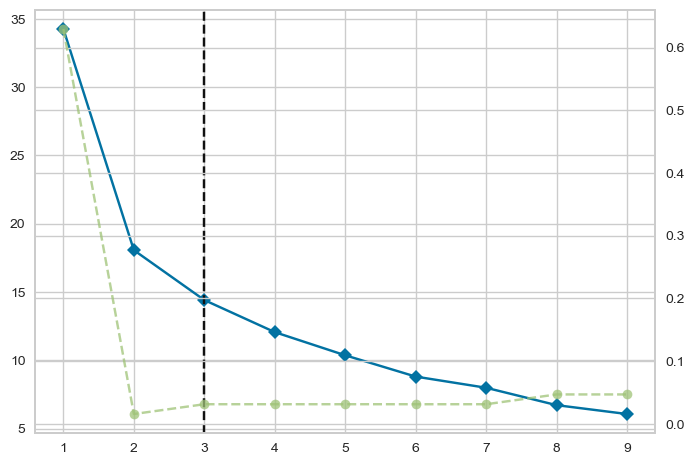

In [27]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_scale)

### 2. Silhouette

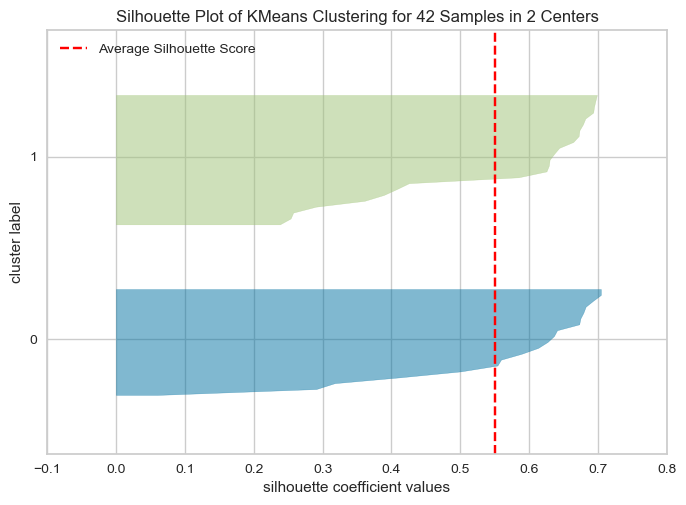

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 42 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [28]:
#클러스터링 모델 생성
kmeans_2 = KMeans(n_clusters=2, init='random')
#visualizer 생성
visualizer_2 = SilhouetteVisualizer(kmeans_2, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_2.fit(Total_df)      
visualizer_2.show()

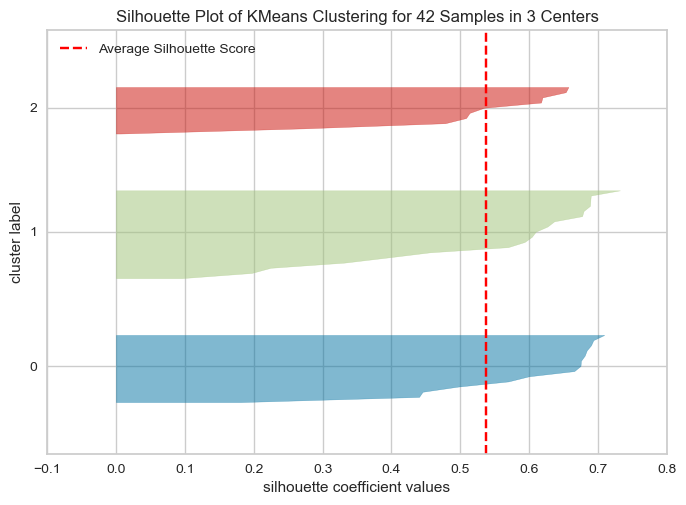

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 42 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [29]:
#클러스터링 모델 생성
kmeans_3 = KMeans(n_clusters=3, init='random')
#visualizer 생성
visualizer_3 = SilhouetteVisualizer(kmeans_3, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_3.fit(Total_df)      
visualizer_3.show()

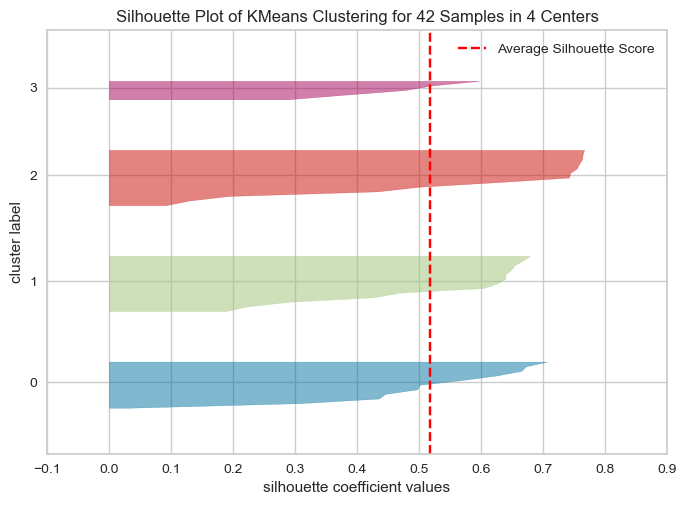

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 42 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [30]:
#클러스터링 모델 생성
kmeans_4 = KMeans(n_clusters=4, random_state=111,init='random')
#visualizer 생성
visualizer_4 = SilhouetteVisualizer(kmeans_4, colors='yellowbrick')
#생성된 visualizer에 데이터 입력 
visualizer_4.fit(Total_df)      
visualizer_4.show()

# 모델링

### K-means

In [32]:
k = 3
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
Total_kmeans = Total_df.copy()
Total_kmeans['cluster'] = model.fit_predict(data_scale)

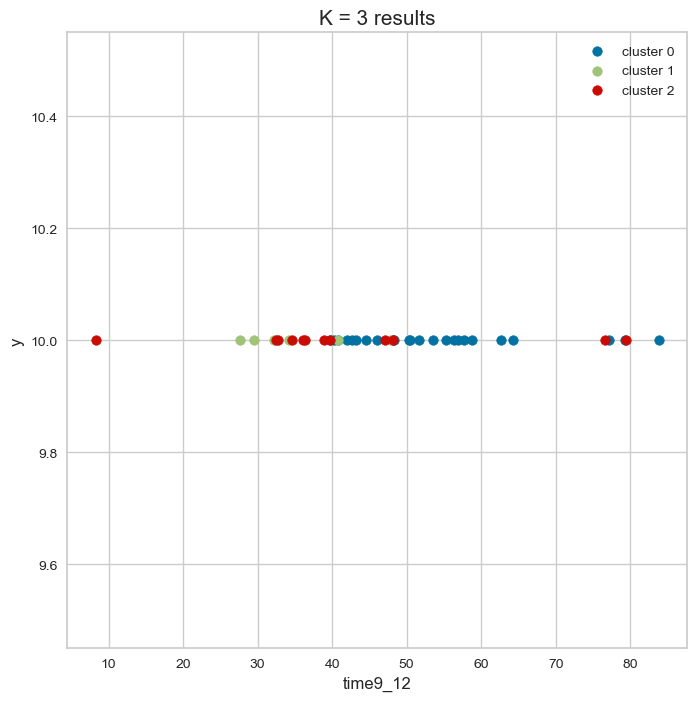

In [34]:
plt.figure(figsize = (8, 8))

c = 1
for i in range(k):
    plt.scatter(Total_kmeans.loc[Total_kmeans['cluster'] == i, Total_kmeans.columns[c]], [10]*len(Total_kmeans.loc[Total_kmeans['cluster'] == i, Total_kmeans.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(Total_kmeans.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()

- cluster 0 :  
- cluster 1 : 오전시간에 혼잡도가 높은 편
- cluster 2 : 오전시간에 혼잡도가 낮은 편

### GMM

In [35]:
gmm = GaussianMixture(n_components=3)
gmm.fit(data_scale)
cluster = gmm.predict(data_scale)
Total_GMM = Total_df.copy()
Total_GMM['cluster'] = cluster

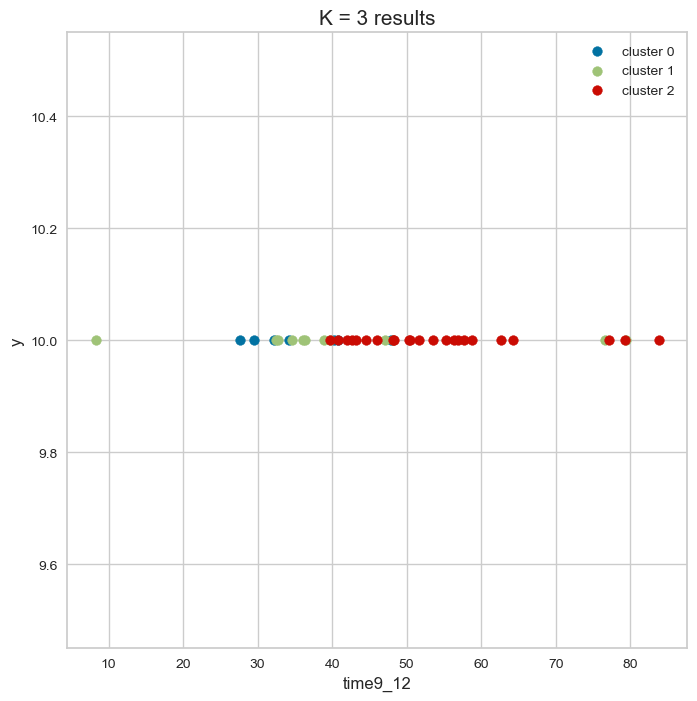

In [36]:
plt.figure(figsize = (8, 8))

c = 1
for i in range(k):
    plt.scatter(Total_GMM.loc[Total_GMM['cluster'] == i, Total_GMM.columns[c]], [10]*len(Total_GMM.loc[Total_GMM['cluster'] == i, Total_GMM.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(Total_GMM.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()

### DBSCAN

In [46]:
dbscan = DBSCAN(eps=0.5,min_samples=4)
cluster = dbscan.fit_predict(data_scale)
Total_DBSCAN = Total_df.copy()
Total_DBSCAN['cluster'] = cluster

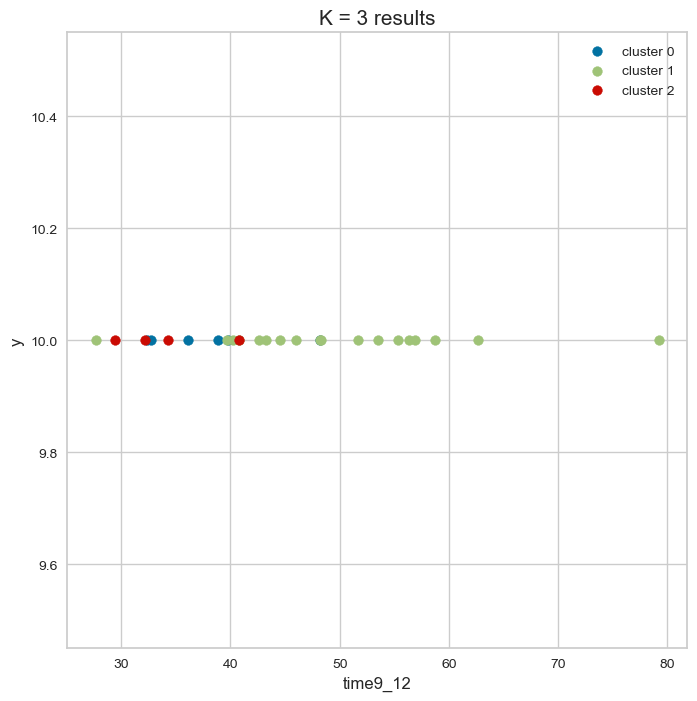

In [47]:
plt.figure(figsize = (8, 8))

c = 1
for i in range(k):
    plt.scatter(Total_DBSCAN.loc[Total_DBSCAN['cluster'] == i, Total_DBSCAN.columns[c]], [10]*len(Total_DBSCAN.loc[Total_DBSCAN['cluster'] == i, Total_DBSCAN.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(Total_DBSCAN.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()

### SOM

In [49]:
som = MiniSom(x = 2, y = 2, input_len = 12)
som.random_weights_init(data_scale)
som.train(data_scale, 100)

In [50]:
import numpy as np
winner_coordinates = np.array([som.winner(x) for x in data_scale]).T
Total_SOM = Total_df.copy()
Total_SOM['cluster'] = np.ravel_multi_index(winner_coordinates,(2,2))

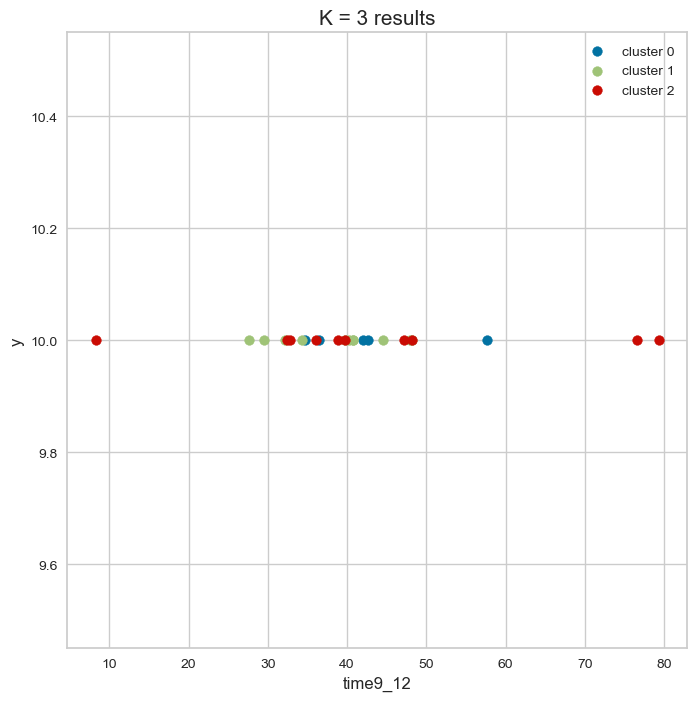

In [52]:
plt.figure(figsize = (8, 8))

c = 1
for i in range(k):
    plt.scatter(Total_SOM.loc[Total_SOM['cluster'] == i, Total_SOM.columns[c]], [10]*len(Total_SOM.loc[Total_SOM['cluster'] == i, Total_SOM.columns[c]]), 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel(Total_SOM.columns[c], size = 12)
plt.ylabel('y', size = 12)
plt.show()